<a href="https://colab.research.google.com/github/ahmad-PH/iml_group_proj/blob/main/LibOfCongress_LSTM_BERT_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

# Do the same but pick GPU
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')
#!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

1


In [2]:
# Checking for GPU in an environment
dev = cuda0
t1 = torch.ones(3, 3, device = dev)
print(t1)

torch.cuda.empty_cache()

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install transformers

In [5]:
import os
import time
import pickle
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple, NamedTuple, Any
from transformers import BertModel, BertTokenizer

DATA_PATH = "github_data"
# BERT_MODEL_NAME = "prajjwal1/bert-tiny"
BERT_MODEL_NAME = "prajjwal1/bert-small" # F1-score of 0.73
#BERT_MODEL_NAME = "bert-base-uncased" # F1-score of 0.77

# Could effect the record with synopsis, but as there aren't many with tokens > 512, ignore for now
MAX_TOKENS_LENGTH = 512 

VERBOSE = True

def tuple_to_df(data: List[Tuple]) -> pd.DataFrame:
    return pd.DataFrame(data, columns=["class", "title", "synopsis", "id"])


def tuple_to_df(data: List[Tuple]) -> pd.DataFrame:
    return pd.DataFrame(data, columns=["class", "title", "synopsis", "id"])

def load(data_path):
    with open(data_path, 'rb') as f:
        classes = pickle.load(f)
        train = pickle.load(f)
        test = pickle.load(f)

        return classes, tuple_to_df(train), tuple_to_df(test)

_, train, test = load("/content/drive/My Drive/trainTest.pk")
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
model = BertModel.from_pretrained(BERT_MODEL_NAME)

def vprint(s):
    if VERBOSE:
        print(s)

class BertData(NamedTuple):
    train_title_embds: Any = None
    train_sypnosis_embds: Any = None
    test_title_embds: Any = None
    test_sypnosis_embds: Any = None

def from_sentences_to_bert_embeddings(sentences: List[str]):
    outputs = []
    for sentence in tqdm(sentences):
        inputs = bert_tokenizer(sentence, truncation=True, max_length=MAX_TOKENS_LENGTH, return_tensors="pt")
        output = model(**inputs)
        outputs.append(output.last_hidden_state.squeeze(0).detach().numpy())
    return outputs

vprint("Getting BERT embeddings...")

result = []

import os

#BERT_FILE = "/content/bert_data_base_uncase.pk"
BERT_FILE = "/content/bert-small.pk"
if not os.path.isfile(BERT_FILE):
  print("File not found, loading...")
  for (titles, synopsis, name) in [(test.title, test.synopsis, "test"),(train.title, train.synopsis, "train")]:
      title_embeddings = from_sentences_to_bert_embeddings(titles)
      synopsis_embeddings = from_sentences_to_bert_embeddings(synopsis)
      assert len(title_embeddings) == len(synopsis_embeddings), f"Title lengths({len(title_embeddings)}) is not equal to synopsis's({len(synopsis_embeddings)})"
      result.append([title_embeddings, synopsis_embeddings])
  data = BertData(result[-1][0], result[-1][1], result[0][0], result[0][1])
  with open(BERT_FILE, 'wb') as f:
      pickle.dump(data, f)
else:
  print("File found, loading...")
  with open(BERT_FILE, "rb") as f:
    data = pickle.load(f)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/111M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting BERT embeddings...
File not found, loading...


100%|██████████| 25526/25526 [11:49<00:00, 35.97it/s]


In [6]:
data.train_sypnosis_embds[0].shape

(17, 512)

In [7]:
import numpy as np
from abc import ABC
import pandas as pd
from typing import Iterable, Tuple, List, NamedTuple, Any
import torch
from os import PathLike, path
import pickle
from sklearn import preprocessing
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pack_sequence
# DATA

class DataBase(ABC, Iterable):
    def __len__(self):
        'Denotes the total number of samples' 
        pass

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        pass

    def get_all(self):
        'Generates one sample of data'
        # Select sample
        pass

    def __iter__(self):
        pass

    def __next__(self): 
        pass

def load_pickle_bert(file_path: str) -> BertData:
    with open(path.join(file_path, 'bert_train.pk'), 'rb') as f:
        [tr_title_embeddings, tr_synopsis_embeddings] = pickle.load(f)

    with open(path.join(file_path, 'bert_test.pk'), 'rb') as f:
        [te_title_embeddings, te_synopsis_embeddings] = pickle.load(f)

    return BertData(
            tr_title_embeddings,
            tr_synopsis_embeddings,
            te_title_embeddings,
            te_synopsis_embeddings
            )

class Keys:
    TRAIN_TITLE="train_title" 
    TRAIN_SYN="train_synopsis"
    TEST_TITLE="test_title"
    TEST_SYN="test_synopsis"


def prep_embds(embds):
    sentence_lengths = np.array([e.shape[0] for e in embds])
    sentence_lengths = np.argsort(-sentence_lengths)
    return (np.array([torch.Tensor(e).to(dev) for e in embds], dtype=object), sentence_lengths)

class DatasetRaw(DataBase):
    def __init__(self, data: BertData, batch_size:int=512, shuffle:bool=True, max_words:int=100):
        le = preprocessing.LabelEncoder()
        y_train = le.fit_transform(train["class"])
        y_test = le.transform(test["class"])

        self.data = data

        self.features = {}
        self.features[Keys.TRAIN_SYN], train_idxes = prep_embds(data.train_sypnosis_embds)
        self.features[Keys.TRAIN_SYN] = self.features[Keys.TRAIN_SYN][train_idxes]
        self.features[Keys.TRAIN_TITLE], _ = prep_embds(data.train_title_embds)
        self.features[Keys.TRAIN_TITLE] = self.features[Keys.TRAIN_TITLE][train_idxes]
        
        self.features[Keys.TEST_SYN], test_idxes = prep_embds(data.test_sypnosis_embds)
        self.features[Keys.TEST_SYN] = self.features[Keys.TEST_SYN][test_idxes]
        self.features[Keys.TEST_TITLE], _ = prep_embds(data.test_title_embds)
        self.features[Keys.TEST_TITLE] = self.features[Keys.TEST_TITLE][test_idxes]
        
        self.train_length = len(self.features[Keys.TRAIN_TITLE])
        
        self.y_train = torch.Tensor(y_train[train_idxes]).long().to(dev)
        self.y_test = torch.Tensor(y_test[test_idxes]).long().to(dev)

        self.batch_size = batch_size
        self.current = 0
        self.shuffle = shuffle

        self.epoch_idxes = np.arange(self.train_length,dtype=int)
        if self.shuffle:
            np.random.shuffle(self.epoch_idxes)


    def __len__(self):
        'Denotes the total number of samples' 
        return self.train_length

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.features[Keys.TRAIN_TITLE][index], self.y_train[index]

    def pack(self, title, synop):
        t_padded = pack_sequence(list(title), enforce_sorted=False)
        s_padded = pack_sequence(list(synop))

        return {
                "x":t_padded,
                "synop":s_padded,
                "x_lengths":len(title)
                }

    def get_all(self):
        # Do paddings
        return (
                #self.pack(self.features[Keys.TRAIN_TITLE], self.features[Keys.TRAIN_SYN]),
                #self.y_train,
                self.pack(self.features[Keys.TEST_TITLE], self.features[Keys.TEST_SYN]),
                self.y_test
                )

    def __iter__(self):
        return self

    def __next__(self):
        # TODO: Batch sorted by sentence sizes, shuffle only batch but not inside the batch.
        if self.current >= self.train_length:
            self.current = 0
            if self.shuffle:
                np.random.shuffle(self.epoch_idxes)
            raise StopIteration

        c = self.current
        self.current += self.batch_size
        selecting_row = self.epoch_idxes[c:c+self.batch_size]
        return self.pack(self.features[Keys.TRAIN_TITLE][selecting_row], self.features[Keys.TRAIN_SYN][selecting_row]), self.y_train[selecting_row]

data_loader = DatasetRaw(data, shuffle=False)
data_loader.__next__()
print("passed")

passed


In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pack_sequence

class LSTM(nn.Module):
    def __init__(self, input_dims: int, num_class: int, hidden_dim:int, num_layers: int):
        super().__init__()
        self.hidden_dim = hidden_dim        
        self.lstm_layers = num_layers

        self.EMB_SIZE = input_dims
        self.title_lstm = nn.LSTM(input_dims, self.hidden_dim, self.lstm_layers, batch_first=True)
        self.synop_lstm = nn.LSTM(input_dims, self.hidden_dim, self.lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)

        self.final = nn.Linear(self.hidden_dim * 2, num_class)
        self.relu = nn.ReLU()

    # Expect 1 row for now
    def forward(self, x, x_lengths, synop):
        h_0 = Variable(torch.zeros(self.lstm_layers, x_lengths, self.hidden_dim)).to(dev) #hidden state
        c_0 = Variable(torch.zeros(self.lstm_layers, x_lengths, self.hidden_dim)).to(dev) #hidden state        

        title_lstm_out, _ = self.title_lstm(x, (h_0, c_0))
        seq_unpacked, lens_unpacked = pad_packed_sequence(title_lstm_out, batch_first=True)
        title_outputs = self.last_timestep(seq_unpacked, lens_unpacked)

        h_1 = Variable(torch.zeros(self.lstm_layers, x_lengths, self.hidden_dim)).to(dev) #hidden state
        c_1 = Variable(torch.zeros(self.lstm_layers, x_lengths, self.hidden_dim)).to(dev) #hidden state                
        synop_lstm_out, _ = self.synop_lstm(synop, (h_1, c_1))
        seq_unpacked, lens_unpacked = pad_packed_sequence(synop_lstm_out, batch_first=True)
        synop_outputs = self.last_timestep(seq_unpacked, lens_unpacked)

        output = torch.cat((title_outputs, synop_outputs), dim=1)
        output = self.final(output)
        return output


    def last_timestep(self, unpacked, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(unpacked.size(0),
                                               unpacked.size(2)).unsqueeze(1).to(dev)
        return unpacked.gather(1, idx).squeeze()

    def predict(self, X):
        return torch.argmax(self.forward(**X), dim=1)

In [9]:
from tqdm import tqdm
from typing import Dict, Any
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import functools
import numpy as np
import pandas as pd
from typing import Callable, Dict, List, Any
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
RANDOM_STATE = 1024
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

class TrainedModel(NamedTuple):
    name: str
    model: Any # Any function that has .predict_proba()
    info: Dict[str, Any] # Information about the training (e.g., is_train?, with_sypnosis?)      


def evaluate_many(models: List[TrainedModel],X_test, y_test):
    results = []
    for trained_model in models:
        clf = trained_model.model
        y_test_pred = clf.predict(X_test).cpu()

        test_row = evaluate(y_test_pred, y_test.cpu(), trained_model.name, trained_model.info)
        test_row["is_train"] = False
        results.append(test_row)

    return pd.DataFrame(results)
  
def precision_recall_f1(label, prediction) -> Dict[str, float]:
    p, r, f, _ = precision_recall_fscore_support(label, prediction, average="macro")

    return {
            "precision": p,
            "recall": r,
            "f1_score": f
    }

def accuracy(label, prediction) -> Dict[str, float]:
    return {
            "accuracy": accuracy_score(label, prediction)
            }

def evaluate(
        prediction,
        label,
        name: str,
        info: Dict[str, Any],
        flows: List[Callable] = [accuracy, precision_recall_f1]
        ):

    flows = flows + [lambda a, b: {"name": name}]
    results = [f(label, prediction) for f in flows] + [info]

    return functools.reduce(
        lambda a,b: {**a, **b}, # Adding two dicts together.
        results
        )

class PyTorchTrainer():

    @staticmethod
    def fit(
            data_loader: DataBase,
            model: nn.Module,
            train_params: Dict[str, Any],
            on_epoch_end: Callable,
            ):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=train_params.get("lr", 0.0001))
        early_stopping_num = train_params.get("early_stopping_num", None)
        last_round_eval_loss = 0

        X_test, y_test = data_loader.get_all()

        for epoch in tqdm(range(train_params.get("epochs", 10)), desc="epochs"):  # loop over the dataset multiple times
            running_loss = 0.0
            metrics = {
                "losses": [],
                "epochs": epoch
            }
            for i, (inputs, labels) in enumerate(data_loader):
                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
                metrics["losses"].append(loss.item())
                loss.backward()
                optimizer.step()
            
            eval_loss = criterion(model(**X_test), y_test)
            metrics["eval_loss"] = eval_loss.item()
            on_epoch_end(metrics)
            if epoch % 5 == 0:
              print("==")
              print(f"Train loss: {loss.item():.5f}")
              print(f"Eval  loss: {eval_loss.item():.5f}")
              print(f"Improvement: {last_round_eval_loss - eval_loss}")
              print("==")

            if early_stopping_num is not None and (last_round_eval_loss - eval_loss) < train_params.get("delta", 0.001):
                early_stopping_num -= 1
                if early_stopping_num <= 0:
                    print("Early stopping! Eval loss hasn't improved for sometimes")
                    break
            else:
              # Reset the early stopping count
              early_stopping_num = train_params.get("early_stopping_num", None)

            last_round_eval_loss = eval_loss
            if epoch % train_params.get("report_epochs", 30) == (train_params.get("report_epochs",30) - 1):
                _model = TrainedModel(name="pytorch_mlp", model=model, info={"epochs": epoch})
                result_df_1 = evaluate_many([_model], X_test, y_test)
                print("===")
                print(result_df_1.head(10))
            
        print("Training done!")
        result_df_1 = evaluate_many([_model], X_test, y_test)
        print("===")
        print(result_df_1.head(10))        
        return None

epochs:   0%|          | 0/600 [00:00<?, ?it/s]

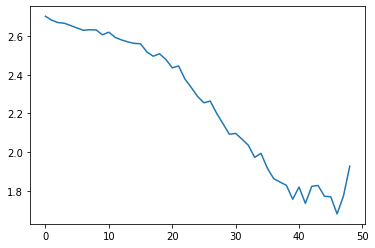

epochs:   0%|          | 1/600 [00:02<24:10,  2.42s/it]

==
Train loss: 1.92702
Eval  loss: 1.70123
Improvement: -1.7012271881103516
==


epochs:   1%|          | 5/600 [00:11<22:36,  2.28s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.655667   0.661468  0.655667  0.652911  pytorch_mlp       4     False


epochs:   1%|          | 6/600 [00:13<22:32,  2.28s/it]

==
Train loss: 0.89528
Eval  loss: 1.11012
Improvement: -0.004317641258239746
==


epochs:   2%|▏         | 10/600 [00:22<22:40,  2.31s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.681333   0.687952  0.681333  0.677952  pytorch_mlp       9     False


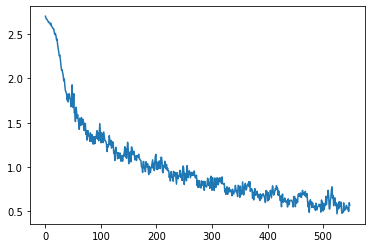

epochs:   2%|▏         | 11/600 [00:25<23:12,  2.36s/it]

==
Train loss: 0.56940
Eval  loss: 1.08569
Improvement: -0.013037681579589844
==


epochs:   2%|▎         | 15/600 [00:34<22:18,  2.29s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.670333   0.683881  0.670333  0.667989  pytorch_mlp      14     False


epochs:   3%|▎         | 16/600 [00:36<22:55,  2.36s/it]

==
Train loss: 0.35615
Eval  loss: 1.17139
Improvement: 0.013684630393981934
==


epochs:   3%|▎         | 20/600 [00:46<22:22,  2.31s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.676667   0.694882  0.676667  0.677275  pytorch_mlp      19     False


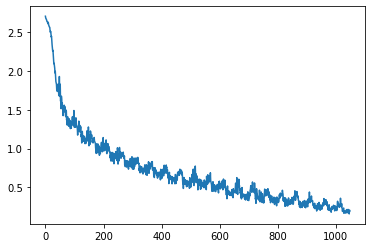

epochs:   4%|▎         | 21/600 [00:48<22:44,  2.36s/it]

==
Train loss: 0.19742
Eval  loss: 1.30087
Improvement: -0.01678943634033203
==


epochs:   4%|▍         | 25/600 [00:57<22:05,  2.30s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.685   0.695381   0.685  0.684205  pytorch_mlp      24     False


epochs:   4%|▍         | 26/600 [00:59<21:50,  2.28s/it]

==
Train loss: 0.09839
Eval  loss: 1.43792
Improvement: -0.032917141914367676
==


epochs:   5%|▌         | 30/600 [01:08<21:38,  2.28s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.657   0.684773   0.657  0.660087  pytorch_mlp      29     False


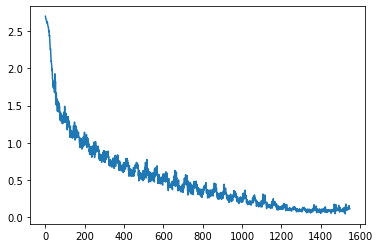

epochs:   5%|▌         | 31/600 [01:11<22:01,  2.32s/it]

==
Train loss: 0.11049
Eval  loss: 1.49291
Improvement: 0.10587012767791748
==


epochs:   6%|▌         | 35/600 [01:20<21:42,  2.31s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.702667   0.708207  0.702667  0.700987  pytorch_mlp      34     False


epochs:   6%|▌         | 36/600 [01:22<21:31,  2.29s/it]

==
Train loss: 0.05382
Eval  loss: 1.55909
Improvement: -0.026412606239318848
==


epochs:   7%|▋         | 40/600 [01:31<21:10,  2.27s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.709   0.715176   0.709  0.710227  pytorch_mlp      39     False


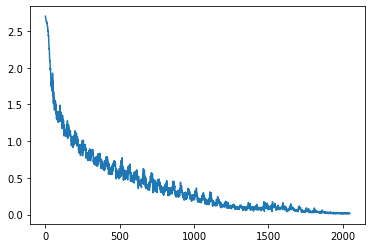

epochs:   7%|▋         | 41/600 [01:34<21:32,  2.31s/it]

==
Train loss: 0.01671
Eval  loss: 1.60053
Improvement: -0.012987136840820312
==


epochs:   8%|▊         | 45/600 [01:43<21:24,  2.31s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.710333   0.712242  0.710333  0.709291  pytorch_mlp      44     False


epochs:   8%|▊         | 46/600 [01:45<21:10,  2.29s/it]

==
Train loss: 0.01192
Eval  loss: 1.65145
Improvement: 0.001251220703125
==


epochs:   8%|▊         | 50/600 [01:54<20:52,  2.28s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.714333   0.716556  0.714333  0.714208  pytorch_mlp      49     False


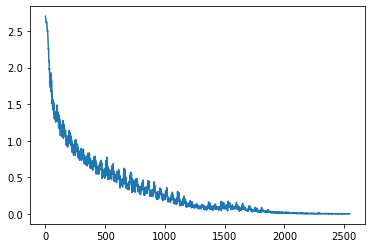

epochs:   8%|▊         | 51/600 [01:57<21:07,  2.31s/it]

==
Train loss: 0.00577
Eval  loss: 1.68095
Improvement: -0.009895563125610352
==


epochs:   9%|▉         | 55/600 [02:06<20:38,  2.27s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.710333   0.712024  0.710333  0.710036  pytorch_mlp      54     False


epochs:   9%|▉         | 56/600 [02:08<20:23,  2.25s/it]

==
Train loss: 0.00429
Eval  loss: 1.71747
Improvement: -0.00603175163269043
==


epochs:  10%|█         | 60/600 [02:17<19:46,  2.20s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.712333   0.713943  0.712333  0.712002  pytorch_mlp      59     False


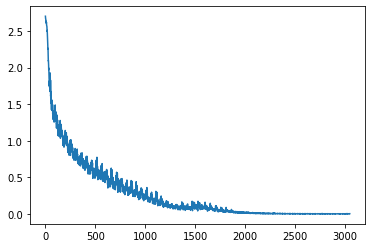

epochs:  10%|█         | 61/600 [02:19<20:21,  2.27s/it]

==
Train loss: 0.00339
Eval  loss: 1.75462
Improvement: -0.013795256614685059
==


epochs:  11%|█         | 65/600 [02:28<20:32,  2.30s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.711333   0.713098  0.711333  0.710965  pytorch_mlp      64     False


epochs:  11%|█         | 66/600 [02:31<20:23,  2.29s/it]

==
Train loss: 0.00270
Eval  loss: 1.78652
Improvement: -0.007347226142883301
==


epochs:  12%|█▏        | 70/600 [02:40<20:17,  2.30s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.713   0.714449   0.713  0.712461  pytorch_mlp      69     False


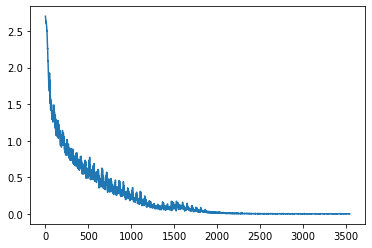

epochs:  12%|█▏        | 71/600 [02:42<20:43,  2.35s/it]

==
Train loss: 0.00225
Eval  loss: 1.81649
Improvement: -0.00816953182220459
==


epochs:  12%|█▎        | 75/600 [02:52<21:00,  2.40s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.713667   0.715496  0.713667  0.713234  pytorch_mlp      74     False


epochs:  13%|█▎        | 76/600 [02:54<20:41,  2.37s/it]

==
Train loss: 0.00187
Eval  loss: 1.84447
Improvement: -0.007582902908325195
==


epochs:  13%|█▎        | 80/600 [03:03<20:08,  2.32s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.713   0.714565   0.713  0.712469  pytorch_mlp      79     False


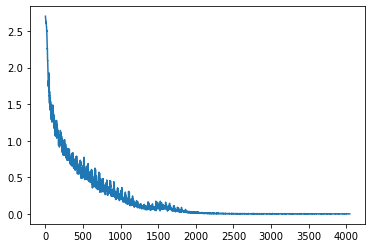

epochs:  14%|█▎        | 81/600 [03:06<20:20,  2.35s/it]

==
Train loss: 0.00158
Eval  loss: 1.87188
Improvement: -0.004773855209350586
==


epochs:  14%|█▍        | 85/600 [03:15<19:30,  2.27s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.712   0.713945   0.712  0.711551  pytorch_mlp      84     False


epochs:  14%|█▍        | 86/600 [03:17<19:21,  2.26s/it]

==
Train loss: 0.00131
Eval  loss: 1.89859
Improvement: -0.005439162254333496
==


epochs:  15%|█▌        | 90/600 [03:26<19:01,  2.24s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0      0.71   0.711931    0.71  0.709644  pytorch_mlp      89     False


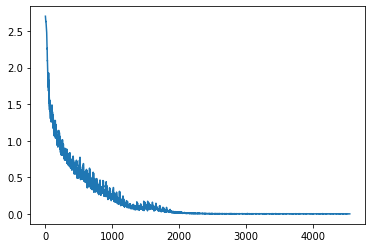

epochs:  15%|█▌        | 91/600 [03:28<19:26,  2.29s/it]

==
Train loss: 0.00114
Eval  loss: 1.92535
Improvement: -0.00508880615234375
==


epochs:  16%|█▌        | 95/600 [03:38<20:56,  2.49s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.711667    0.71339  0.711667  0.711107  pytorch_mlp      94     False


epochs:  16%|█▌        | 96/600 [03:40<20:16,  2.41s/it]

==
Train loss: 0.00096
Eval  loss: 1.94594
Improvement: -0.004317283630371094
==


epochs:  17%|█▋        | 100/600 [03:50<19:34,  2.35s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.712   0.713425   0.712   0.71136  pytorch_mlp      99     False


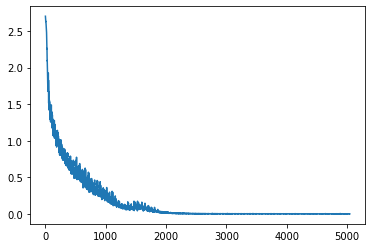

epochs:  17%|█▋        | 101/600 [03:52<19:38,  2.36s/it]

==
Train loss: 0.00084
Eval  loss: 1.97453
Improvement: -0.004960894584655762
==


epochs:  18%|█▊        | 105/600 [04:01<18:39,  2.26s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.709333     0.7111  0.709333  0.708743  pytorch_mlp     104     False


epochs:  18%|█▊        | 106/600 [04:03<18:29,  2.25s/it]

==
Train loss: 0.00072
Eval  loss: 2.00107
Improvement: -0.008738279342651367
==


epochs:  18%|█▊        | 110/600 [04:12<18:16,  2.24s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0      0.71   0.711512    0.71  0.709091  pytorch_mlp     109     False


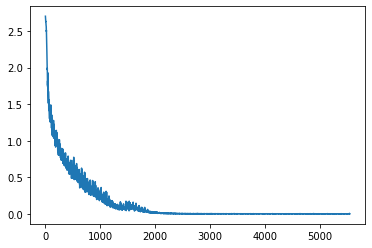

epochs:  18%|█▊        | 111/600 [04:14<18:41,  2.29s/it]

==
Train loss: 0.00095
Eval  loss: 2.01401
Improvement: 0.012738227844238281
==


epochs:  19%|█▉        | 115/600 [04:23<18:22,  2.27s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.691667     0.6984  0.691667   0.69125  pytorch_mlp     114     False


epochs:  19%|█▉        | 116/600 [04:26<18:18,  2.27s/it]

==
Train loss: 0.06874
Eval  loss: 1.69398
Improvement: -0.07309198379516602
==


epochs:  20%|██        | 120/600 [04:35<18:00,  2.25s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.708333   0.712266  0.708333  0.708001  pytorch_mlp     119     False


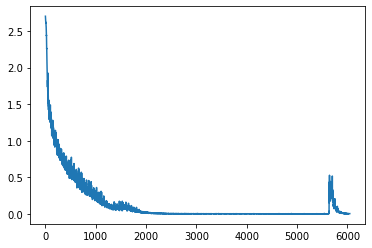

epochs:  20%|██        | 121/600 [04:37<18:31,  2.32s/it]

==
Train loss: 0.00427
Eval  loss: 1.75544
Improvement: 0.0066623687744140625
==


epochs:  21%|██        | 125/600 [04:46<17:52,  2.26s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.718333   0.719441  0.718333  0.717463  pytorch_mlp     124     False


epochs:  21%|██        | 126/600 [04:48<17:44,  2.25s/it]

==
Train loss: 0.00234
Eval  loss: 1.81575
Improvement: -0.009231090545654297
==


epochs:  22%|██▏       | 130/600 [04:57<17:58,  2.29s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.723   0.723796   0.723   0.72207  pytorch_mlp     129     False


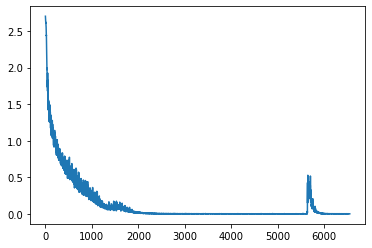

epochs:  22%|██▏       | 131/600 [05:00<18:09,  2.32s/it]

==
Train loss: 0.00171
Eval  loss: 1.85761
Improvement: -0.008434772491455078
==


epochs:  22%|██▎       | 135/600 [05:09<17:52,  2.31s/it]

===
   accuracy  precision  recall  f1_score         name  epochs  is_train
0     0.723   0.723819   0.723  0.722015  pytorch_mlp     134     False


epochs:  23%|██▎       | 136/600 [05:11<17:43,  2.29s/it]

==
Train loss: 0.00131
Eval  loss: 1.89103
Improvement: -0.005332827568054199
==


epochs:  23%|██▎       | 140/600 [05:20<17:17,  2.25s/it]

===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.722333   0.723437  0.722333  0.721482  pytorch_mlp     139     False


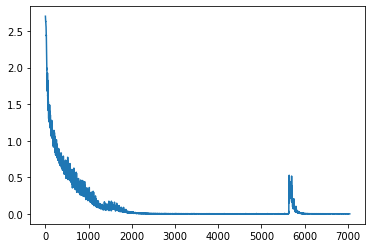

epochs:  23%|██▎       | 140/600 [05:23<17:41,  2.31s/it]

==
Train loss: 0.00106
Eval  loss: 1.92224
Improvement: -0.006294727325439453
==
Early stopping! Eval loss hasn't improved for sometimes
Training done!
===
   accuracy  precision    recall  f1_score         name  epochs  is_train
0  0.723333   0.724294  0.723333  0.722451  pytorch_mlp     139     False


In [13]:
import matplotlib.pyplot as plt
training_params = {
        "epochs": 600,
        "lr": 0.001,
        "report_epochs":5,
        "early_stopping_num": 20,
        "delta": 0.0001
}

tmp, _ = data_loader.__next__()
model = LSTM(data_loader[0][0].shape[1], 15, 128, 2).to(dev)
lstm_output = model.forward(**tmp)

losses = []
def report(metrics):
  losses.extend(metrics["losses"])
  if metrics["epochs"] % 10 == 0:
    plt.clf()
    plt.plot(losses)
    plt.show()

PyTorchTrainer.fit(data_loader, model, training_params, report)

In [11]:
torch.save(model, "/content/bert_lstm_256.pt")